In [1]:
#Import Libraries

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import os

ModuleNotFoundError: No module named 'sklearn'

In [3]:
#Initialization with 20 Epochs and 32 Batches and set images' path

In [4]:
initLayer = 1e-4
epochs = 5
batch = 32

In [5]:
#SettingUp Image Data

In [6]:
directory = "/home/karem/Documents/Python/FaceMaskDetection/dataset"
categories = ["withMask", "withoutMask"]
data = []
labels = []
for category in categories:
    path = os.path.join(directory, category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(224, 224))
    	image = img_to_array(image)
    	image = preprocess_input(image)
    	data.append(image)
    	labels.append(category)

In [7]:
#Encode Data and Labels

In [8]:
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
labels = to_categorical(labels)
data = np.array(data,dtype="float32")
labels = np.array(labels)

In [9]:
#Set 80% of Images for training and 20% for testing

In [10]:
(trainX,testX,trainY,testY) = train_test_split(data,labels,test_size=0.20,stratify=labels,random_state=20)

In [11]:
aug = ImageDataGenerator(
	rotation_range=20,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")

In [12]:
#Load MibileNetV2 network

In [13]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

In [14]:
#Construct the head module

In [15]:
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)

In [16]:
# Pace the head FC model on top of the base model (this will become the actual model we will train)

In [17]:
model = Model(inputs=baseModel.input, outputs=headModel)

In [18]:
#Loop over all layers in the base model and freeze them so they will not be updated during the first training process

In [19]:
for layer in baseModel.layers:
	layer.trainable = False

In [20]:
#Compile the neural network Module

In [21]:
opt = Adam(lr=initLayer, decay=initLayer / epochs)
model.compile(loss="binary_crossentropy", optimizer=opt,
	metrics=["accuracy"])

In [22]:
#Train the head of the module

In [23]:
H = model.fit(aug.flow(trainX, trainY, batch_size=batch),
	steps_per_epoch=len(trainX) // batch,
	validation_data=(testX, testY),
	validation_steps=len(testX) // batch,
	epochs=epochs)

Epoch 1/5
95/95 [==============================] - 98s 1s/step - loss: 0.2674 - accuracy: 0.8813 - val_loss: 0.0824 - val_accuracy: 0.9752
Epoch 2/5
95/95 [==============================] - 98s 1s/step - loss: 0.1011 - accuracy: 0.9667 - val_loss: 0.0577 - val_accuracy: 0.9831
Epoch 3/5
95/95 [==============================] - 96s 1s/step - loss: 0.0831 - accuracy: 0.9726 - val_loss: 0.0477 - val_accuracy: 0.9844
Epoch 4/5
95/95 [==============================] - 99s 1s/step - loss: 0.0648 - accuracy: 0.9763 - val_loss: 0.0381 - val_accuracy: 0.9844
Epoch 5/5
95/95 [==============================] - 97s 1s/step - loss: 0.0554 - accuracy: 0.9806 - val_loss: 0.0310 - val_accuracy: 0.9870


In [24]:
#Serialize the model to disk

In [25]:
model.save("mask_detector.model", save_format="h5")

In [26]:
# plot the training loss and accuracy


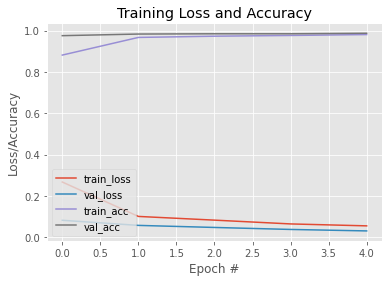

In [28]:
N = epochs
plot.style.use("ggplot")
plot.figure()
plot.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plot.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plot.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plot.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plot.title("Training Loss and Accuracy")
plot.xlabel("Epoch #")
plot.ylabel("Loss/Accuracy")
plot.legend(loc="lower left")
plot.savefig("plot.png")